- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-02-07 14:32:47.003257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 14:32:47.484888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-07 14:32:48.199978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-07 14:32:48.200200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-07 14:32:48.222181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import cv2
import torch
import timm
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.cuda.amp as amp
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle

In [3]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [4]:
# Define the correct base path
correct_base_path = "/media/yu-tingtseng_sa/Data1"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
# print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

In [5]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

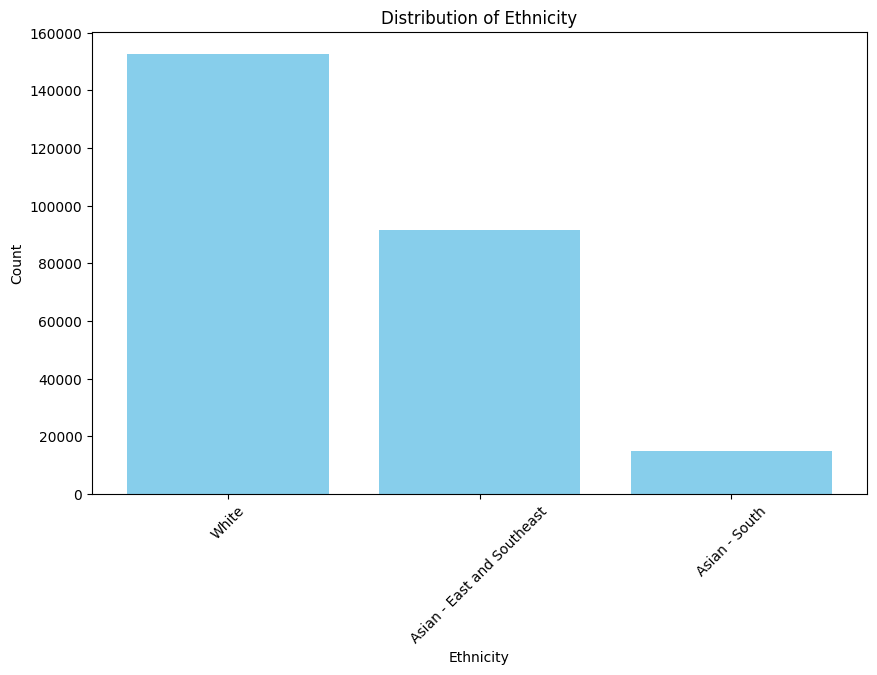

In [8]:
# Count ethnicity distribution
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Stratified sampling: Select 6000 images per ethnicity
target_per_class = 6000
stratified_samples = []

# For each ethnicity, sample up to 6000
for ethnicity, group in data.groupby('ethnicity'):
    stratified_samples.append(group.sample(
        n=min(target_per_class, len(group)),  # Use all if less than target_per_class
        random_state=42
    ))

# Combine the samples into one DataFrame
data_sample = pd.concat(stratified_samples, ignore_index=True)

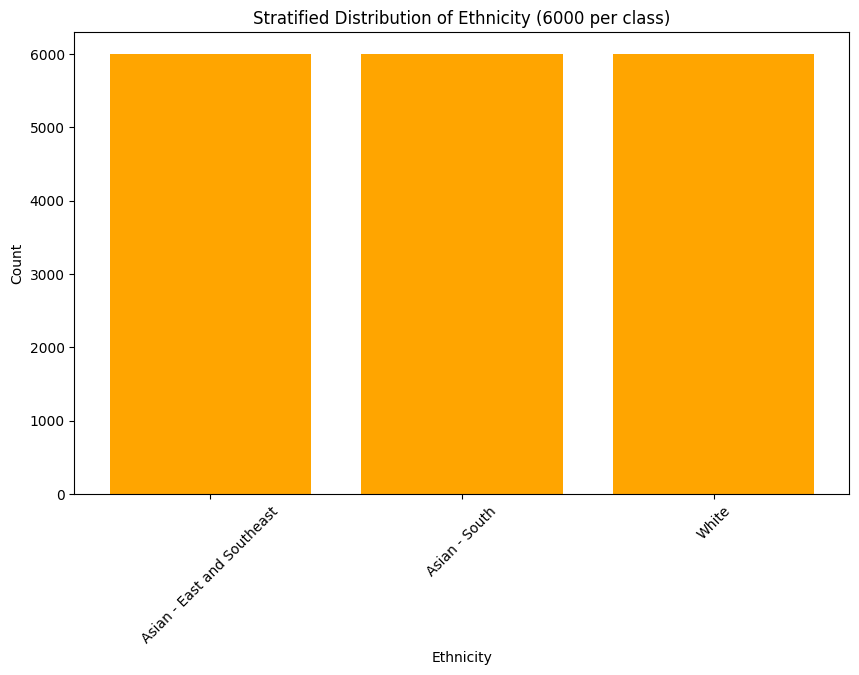

In [10]:
# Show the new distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Stratified Distribution of Ethnicity (6000 per class)')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [51]:
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)

    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)

    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    imgCropped = img[y:y+h, x:x+w]

    # Make the cropped image square by padding
    max_dim = max(w, h)
    padded_img = cv2.copyMakeBorder(
        imgCropped,
        top=(max_dim - h) // 2,
        bottom=(max_dim - h + 1) // 2,
        left=(max_dim - w) // 2,
        right=(max_dim - w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Background color (black)
    )

    # Save the processed image to a unique directory based on the original file path
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, imgCropped)
    cv2.imwrite(output_path, padded_img)

    return output_path

In [52]:
# Directory for saving preprocessed images
output_dir = "/tmp/512_processed_images"
os.makedirs(output_dir, exist_ok=True)

# Prepare LCC-only file paths and labels
lcc_only_filepaths = []
lcc_only_labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        if lcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(lcc_cropped_path)
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

print(f"Number of valid LCC-only images: {len(lcc_only_filepaths)}")
print(f"Distribution of valid LCC-only images: {Counter(lcc_only_labels)}")

# Split dataset into train/test
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    lcc_only_filepaths, lcc_only_labels, test_size=0.25, stratify=lcc_only_labels, random_state=42
)

Number of valid LCC-only images: 17972
Distribution of valid LCC-only images: Counter({'Asian - East and Southeast': 6011, 'White': 5987, 'Asian - South': 5974})


### Convert to Labels

In [39]:
# Label encoding
label_mapping = {label: idx for idx, label in enumerate(set(train_lcc_labels))}
train_labels = [label_mapping[label] for label in train_lcc_labels]
test_labels = [label_mapping[label] for label in test_lcc_labels]

# Define transformations (includes horizontal flipping for data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset
class LCCDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# DataLoaders
# train_loader = DataLoader(LCCDataset(train_lcc_filepaths, train_labels, transform=transform_train), batch_size=8, shuffle=True, num_workers=4)
# test_loader = DataLoader(LCCDataset(test_lcc_filepaths, test_labels, transform=transform_test), batch_size=8, shuffle=False, num_workers=4)

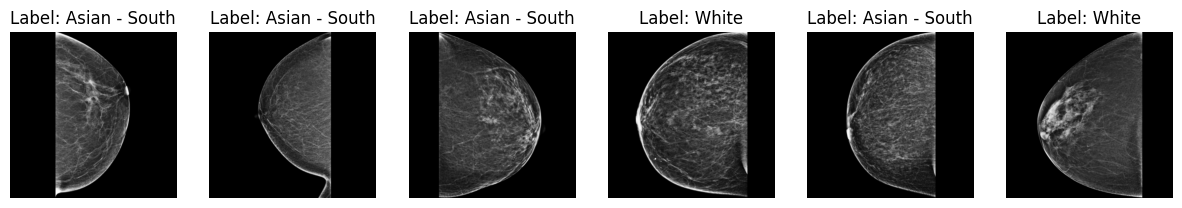

In [14]:
# Visualize augmented images
def show_augmented_images(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert tensor to NumPy image
        axes[i].imshow(image.squeeze(), cmap='gray')  # Single-channel images
        axes[i].set_title(f"Label: {list(label_mapping.keys())[label]}")
        axes[i].axis("off")
    plt.show()

show_augmented_images(train_loader.dataset)


### Save Processed Data

In [22]:
import pickle

# Define the save path for metadata
metadata_path = "/tmp/dinov2/224_lcc_dataset_metadata.pkl"

# Save metadata (file paths and labels)
with open(metadata_path, "wb") as f:
    pickle.dump({
        "train_filepaths": train_lcc_filepaths,
        "test_filepaths": test_lcc_filepaths,
        "train_labels": train_lcc_labels,
        "test_labels": test_lcc_labels,
        "label_mapping": label_mapping
    }, f)

print(f"Metadata saved at {metadata_path}")

Metadata saved at /tmp/dinov2/1024_lcc_dataset_metadata.pkl


### Reload Saved Data

In [29]:
metadata_path = "/tmp/dinov2/224_lcc_dataset_metadata.pkl"

# Load metadata
with open(metadata_path, "rb") as f:
    metadata = pickle.load(f)

# Retrieve file paths and labels
train_lcc_filepaths = metadata["train_filepaths"]
test_lcc_filepaths = metadata["test_filepaths"]
train_lcc_labels = metadata["train_labels"]
test_lcc_labels = metadata["test_labels"]
label_mapping = metadata["label_mapping"]

# Convert string labels to encoded labels again
train_labels = [label_mapping[label] for label in train_lcc_labels]
test_labels = [label_mapping[label] for label in test_lcc_labels]

print("Metadata successfully loaded!")

Metadata successfully loaded!


### Recreate the Dataset and DataLoader

In [40]:
# Recreate DataLoaders
train_loader = DataLoader(LCCDataset(train_lcc_filepaths, train_labels, transform=transform_train), batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(LCCDataset(test_lcc_filepaths, test_labels, transform=transform_test), batch_size=16, shuffle=False, num_workers=4)

print("DataLoaders are ready for training and evaluation!")

DataLoaders are ready for training and evaluation!


In [41]:
torch.cuda.set_device(1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda:1


In [ ]:
# Load DINOv2 model (224x224 version) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
dinov2_model = timm.create_model("vit_base_patch14_dinov2.lvd142m", pretrained=True, interpolate_pos_embed=True) 

# Freeze all backbone layers 
for param in dinov2_model.parameters(): 
    param.requires_grad = False  # backbone frozen 
    
# Replace classifier head 
num_features = dinov2_model.num_features
dinov2_model.head = nn.Linear(num_features, len(label_mapping)) 

# Enable gradient updates for classifier 
for param in dinov2_model.head.parameters(): 
    param.requires_grad = True

# Move model to GPU 
dinov2_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dinov2_model.head.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = amp.GradScaler()

# Train model with AMP
train_losses, val_losses, train_accs, val_accs = [], [], [], []

In [43]:
from transformers import AutoModel, AutoImageProcessor

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load DINOv2 backbone from Hugging Face
model_name = "facebook/dinov2-base"  # Equivalent to "vit_base_patch14_dinov2.lvd142m"
dinov2_model = AutoModel.from_pretrained(model_name)


# Freeze all backbone layers
for param in dinov2_model.parameters():
    param.requires_grad = False  # Freeze DINOv2 backbone


# Get feature size (last hidden state dimension)
num_features = dinov2_model.config.hidden_size  # Typically 768 for ViT-Base

# Define a new classification head
num_classes = len(label_mapping)  # Set your number of output classes
dinov2_model.classifier = nn.Linear(num_features, num_classes)  # Replace classifier


# Enable gradient updates for the classifier head
for param in dinov2_model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU 
dinov2_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dinov2_model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = amp.GradScaler()

# Train model with AMP
train_losses, val_losses, train_accs, val_accs = [], [], [], []

In [44]:
# Train model
def train(model, train_loader, test_loader, criterion, optimizer, scaler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with amp.autocast():
                outputs = model(images)  # Forward pass
                cls_token = outputs.pooler_output  # Use `pooler_output`
                logits = model.classifier(cls_token)  # Pass CLS token through classifier head
                loss = criterion(logits, labels)  # Compute loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            correct += logits.argmax(1).eq(labels).sum().item()
            total += labels.size(0)
        
        # Training loss & accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation step
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with amp.autocast():
                    outputs = model(images)
                    cls_token = outputs.pooler_output  # Use `pooler_output`
                    logits = model.classifier(cls_token)
                    loss = criterion(logits, labels)
                val_loss += loss.item()
                val_correct += logits.argmax(1).eq(labels).sum().item()
                val_total += labels.size(0)

        # Validation loss & accuracy
        val_loss /= len(test_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

train(dinov2_model, train_loader, test_loader, criterion, optimizer, scaler, device, num_epochs=10)

Epoch 1: Train Loss: 0.9039, Train Acc: 57.88% | Val Loss: 0.8159, Val Acc: 62.54%
Epoch 2: Train Loss: 0.8465, Train Acc: 61.66% | Val Loss: 0.8545, Val Acc: 60.34%
Epoch 3: Train Loss: 0.8258, Train Acc: 63.00% | Val Loss: 0.8122, Val Acc: 64.52%
Epoch 4: Train Loss: 0.8249, Train Acc: 63.08% | Val Loss: 0.9249, Val Acc: 55.71%
Epoch 5: Train Loss: 0.8060, Train Acc: 64.26% | Val Loss: 0.8044, Val Acc: 64.90%
Epoch 6: Train Loss: 0.8027, Train Acc: 64.66% | Val Loss: 0.7838, Val Acc: 65.12%
Epoch 7: Train Loss: 0.7958, Train Acc: 64.96% | Val Loss: 0.7814, Val Acc: 66.17%
Epoch 8: Train Loss: 0.7953, Train Acc: 64.80% | Val Loss: 0.9858, Val Acc: 59.67%
Epoch 9: Train Loss: 0.7892, Train Acc: 64.98% | Val Loss: 0.7731, Val Acc: 66.86%
Epoch 10: Train Loss: 0.7918, Train Acc: 65.64% | Val Loss: 0.8554, Val Acc: 62.63%


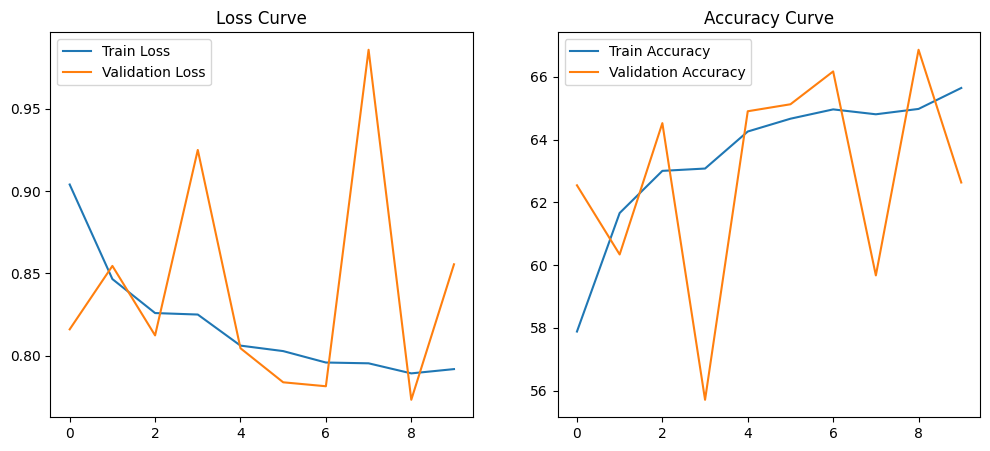

In [48]:
# Plot Training & Validation Loss/Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

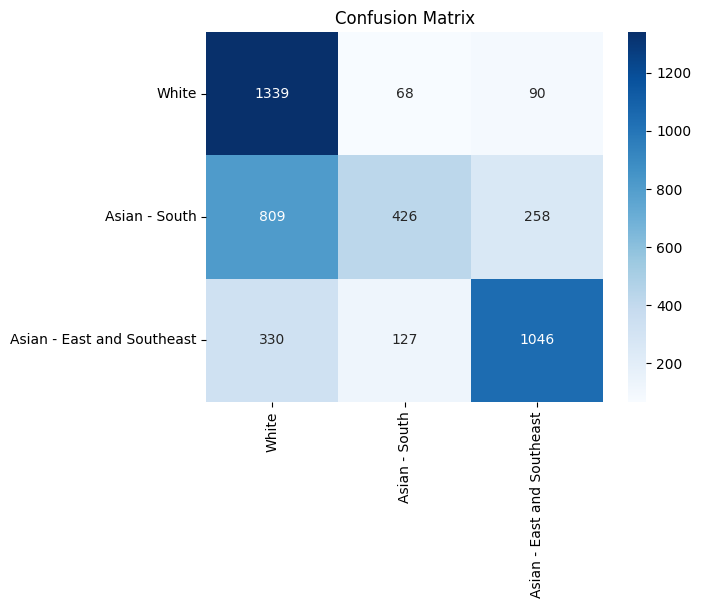

Classification Report:
                            precision    recall  f1-score   support

                     White       0.54      0.89      0.67      1497
             Asian - South       0.69      0.29      0.40      1493
Asian - East and Southeast       0.75      0.70      0.72      1503

                  accuracy                           0.63      4493
                 macro avg       0.66      0.63      0.60      4493
              weighted avg       0.66      0.63      0.60      4493



In [46]:
# Evaluation
dinov2_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = dinov2_model(images).pooler_output  # Extract CLS token
        logits = dinov2_model.classifier(outputs)  # Pass through classifier head
        predictions = logits.argmax(1)  # Get predicted class

        # Ensure equal lengths
        y_true.extend(labels.cpu().tolist())  # Convert tensor to list
        y_pred.extend(predictions.cpu().tolist())  # Convert tensor to list

# Check final lengths before computing metrics
assert len(y_true) == len(y_pred), f"Mismatch in lengths: y_true={len(y_true)}, y_pred={len(y_pred)}"

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

In [47]:
# Convert Multi-Class to Binary for Each Class & Compute Sensitivity/Specificity
ethnicities = list(label_mapping.keys())

print("Sensitivity & Specificity for Each Class:\n")
for i, ethnicity in enumerate(ethnicities):
    binary_true = [1 if y == i else 0 for y in y_true]  # 1 = ethnicity, 0 = other ethnicities
    binary_pred = [1 if y == i else 0 for y in y_pred]  # 1 = model predicts ethnicity, 0 = otherwise

    tn, fp, fn, tp = confusion_matrix(binary_true, binary_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    print(f"{ethnicity}:")
    print(f"   - Sensitivity (Recall): {sensitivity:.4f}")
    print(f"   - Specificity: {specificity:.4f}\n")

Sensitivity & Specificity for Each Class:

White:
   - Sensitivity (Recall): 0.8945
   - Specificity: 0.6198

Asian - South:
   - Sensitivity (Recall): 0.2853
   - Specificity: 0.9350

Asian - East and Southeast:
   - Sensitivity (Recall): 0.6959
   - Specificity: 0.8836



In [63]:
torch.save(dinov2_model.state_dict(), "Mammo_DINOv2_3class_512_model.pth")
print("Model weights saved successfully!")

Model weights saved successfully!


In [ ]:
'''
# Reinitialize the model
dinov2_base = timm.create_model("vit_base_patch14_dinov2.lvd142m", pretrained=True)
dinov2_model = DINOv2Classifier(dinov2_base, num_classes)
dinov2_model.load_state_dict(torch.load("dinov2_lcc_model.pth"))
dinov2_model.to(device)  # Move to GPU if available
dinov2_model.eval()  # Set model to evaluation mode
print("✅ Model loaded successfully!")
'''